In [138]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Modeling Evaluation
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Pipeline
from imblearn.pipeline import make_pipeline

import os, sys

sys.path.append("../../src")
from helper_functions import MAPE, plot_feature_importances, plot_top5_feature_importances, plot_obs_pred

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sns.set(context = 'notebook', style = 'whitegrid')
ppt_colors = ['#9146ff', '#571dad', '#9168cd', '#bd9eeb', '#b58eee', '#b48bf0']

In [3]:
# Data should be placed in the data/raw folder in order to run the code

raw_data_path = os.path.join(os.pardir, os.pardir, "data", "raw", "twitchdata-update.csv")
df_twitch = pd.read_csv(raw_data_path)

In [4]:
# Let's look at the data

df_twitch.head(5)

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,False,English
1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,False,English
2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,True,Portuguese
3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,False,English
4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,False,English


# Initial EDA

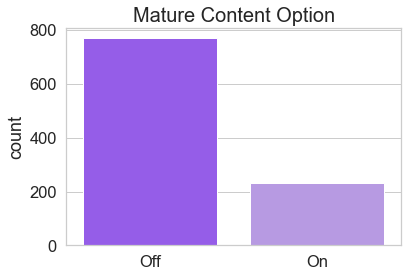

In [5]:
# Mature content or Not

sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1.5)

ax = sns.countplot(x = 'Mature', data = df_twitch, palette = [ppt_colors[0], ppt_colors[4]])
ax.set(xlabel = '', xticklabels = ['Off', 'On'])
ax.set_title('Mature Content Option', fontdict={'fontsize': 20})

#plt.savefig('../../reports/figures/Mature.png', dpi = 500, bbox_inches = 'tight', transparent = True)
plt.show()

In [14]:
df_twitch.Mature.value_counts()

0    770
1    230
Name: Mature, dtype: int64

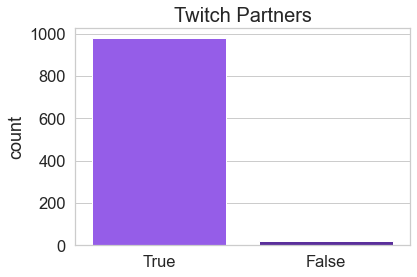

In [7]:
# Partnered or Not

sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1.5)

ax = sns.countplot(x = 'Partnered', data = df_twitch, palette = [ppt_colors[0], ppt_colors[1]], order = df_twitch['Partnered'].value_counts().index)
ax.set(xlabel = '', xticklabels = ['True', 'False'])
ax.set_title('Twitch Partners', fontdict={'fontsize': 20})

#plt.savefig('../../reports/figures/Partnered.png', dpi = 500, bbox_inches = 'tight', transparent = True)
plt.show()

In [12]:
df_twitch.Partnered.value_counts()

1    978
0     22
Name: Partnered, dtype: int64

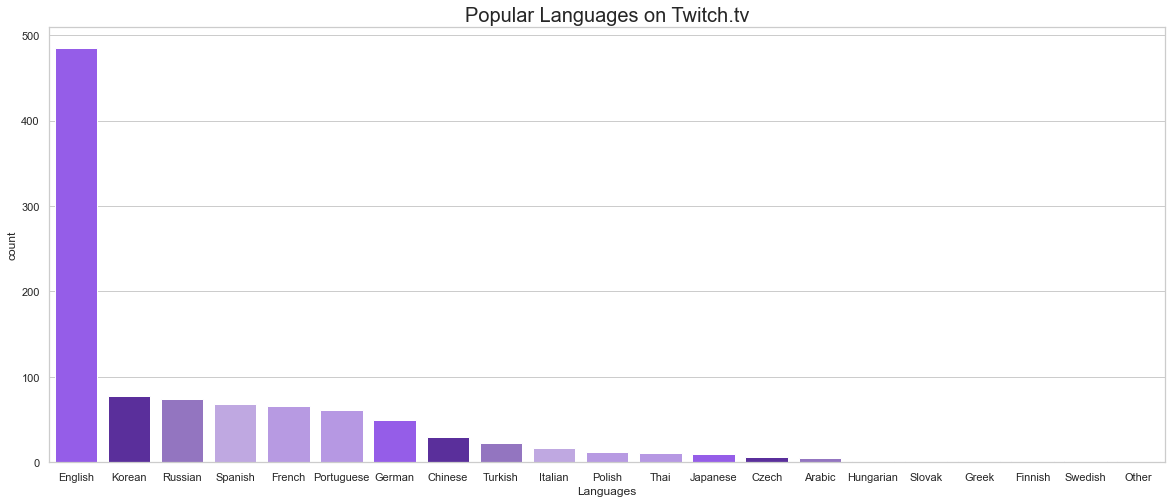

In [9]:
# Language breakdown
plt.figure(figsize=(20, 8))
sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1)
xlabel = 'Languages'
ylabel = 'count'

ax = sns.countplot(x = 'Language', data = df_twitch, order = df_twitch['Language'].value_counts().index, palette = ppt_colors)
ax.set(xlabel = xlabel, ylabel = ylabel)
ax.set_title('Popular Languages on Twitch.tv', fontdict={'fontsize': 20})

#plt.savefig('../../reports/figures/Languages.png', dpi = 500, bbox_inches = 'tight', transparent = True)
plt.show()

In [10]:
df_twitch.Language.value_counts()

English       485
Korean         77
Russian        74
Spanish        68
French         66
Portuguese     61
German         49
Chinese        30
Turkish        22
Italian        17
Polish         12
Thai           11
Japanese       10
Czech           6
Arabic          5
Hungarian       2
Slovak          1
Greek           1
Finnish         1
Swedish         1
Other           1
Name: Language, dtype: int64

In [11]:
# Label Encoding Partnered column True : 1, False : 0 

Partnered_le = df_twitch.Partnered

le = LabelEncoder()
le.fit(Partnered_le)
df_twitch.Partnered = le.transform(Partnered_le)
df_twitch.Partnered

0      1
1      1
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: Partnered, Length: 1000, dtype: int64

In [13]:
# Label Encoding Mature column True : 1, False : 0 

Mature_le = df_twitch.Mature

le = LabelEncoder()
le.fit(Mature_le)
df_twitch.Mature = le.transform(Mature_le)
df_twitch.Mature

0      0
1      0
2      1
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: Mature, Length: 1000, dtype: int64

In [15]:
# Label Encoding Language column, numbers assigned to languages by default.

Language_le = df_twitch.Language

le = LabelEncoder()
le.fit(Language_le)
df_twitch.Language = le.transform(Language_le)
df_twitch.Language

0       3
1       3
2      14
3       3
4       3
       ..
995    17
996    11
997    11
998     3
999     5
Name: Language, Length: 1000, dtype: int64

In [16]:
# Set a channel name as an index

df_twitch.set_index('Channel', drop=True, inplace=True)
df_twitch.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
Channel,,,,,,,,,,
xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,1,0,3
summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,1,0,3
Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,1,1,14
ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,1,0,3
Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,1,0,3


In [14]:
df_twitch_drop = df_twitch[df_twitch['Followers gained'] < 200].index
df_twitch_drop

Index(['Amaz', 'TSM_TheOddOne', 'Dyrus', '마스카 (newmasca)'], dtype='object', name='Channel')

In [15]:
df_twitch = df_twitch.drop(df_twitch_drop)

In [16]:
df_twitch

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
Channel,,,,,,,,,,
xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,1,0,3
summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,1,0,3
Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,1,1,14
ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,1,0,3
Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,1,0,3
...,...,...,...,...,...,...,...,...,...,...
Destructoid,122628630,103020,14566,1190,48007,8995,87603521,1,0,3
LITkillah,122524635,13560,21359,9104,601927,562691,2162107,1,0,17
빅헤드 (bighead033),122523705,153000,3940,793,213212,52289,4399897,1,0,11


In [123]:
# clean data

df_twitch.to_csv('../../data/clean/CleanData.csv')

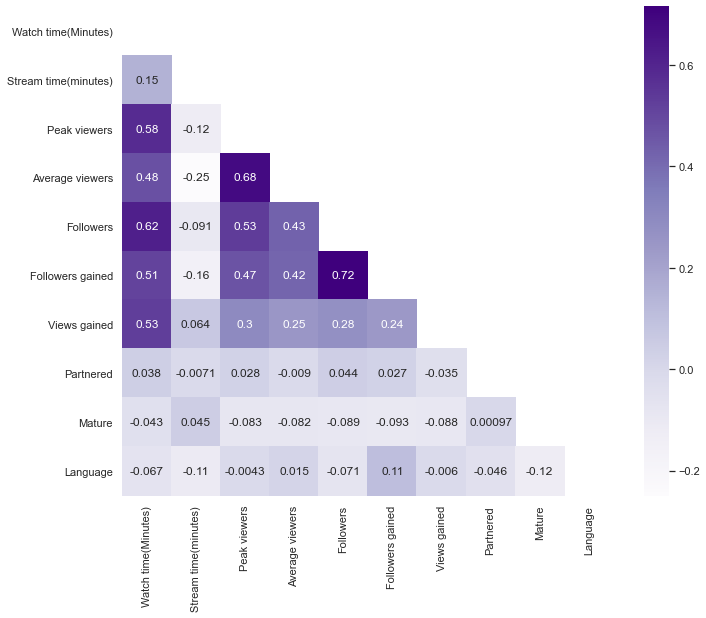

In [17]:
corr = df_twitch.corr()
#corr.style.background_gradient()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, annot=True, mask=mask, ax=ax1, cmap="Purples");


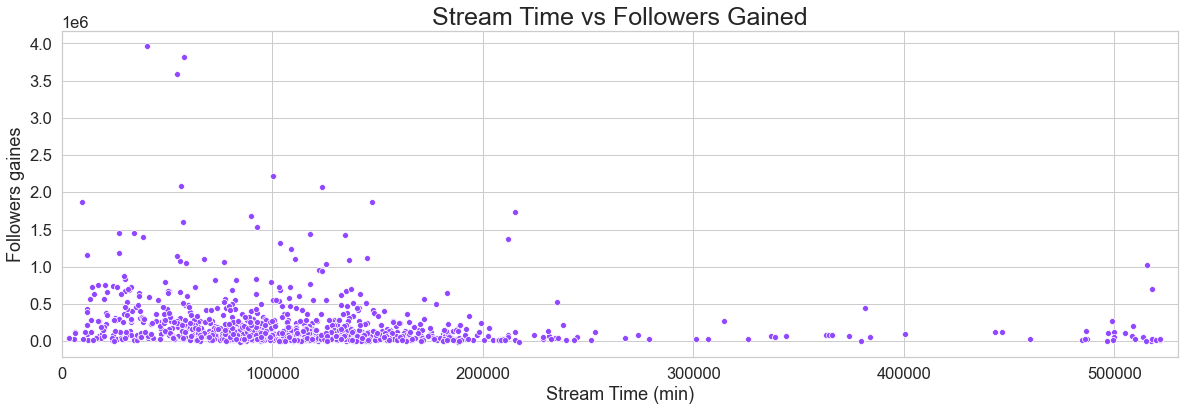

In [18]:
# Scatter plot
plt.figure(figsize=(20, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1.5)

line = sns.scatterplot(x='Stream time(minutes)', y='Followers gained', data=df_twitch,  color = "#9146ff")
line.set(xlabel='Stream Time (min)', ylabel='Followers gaines')
line.set_title('Stream Time vs Followers Gained', fontdict={'fontsize': 25})
plt.xlim(left=0, right=5.3e5)

plt.savefig("../../reports/figures/StreamTimevsFollowersgained.png", bbox_inches='tight', dpi=500)

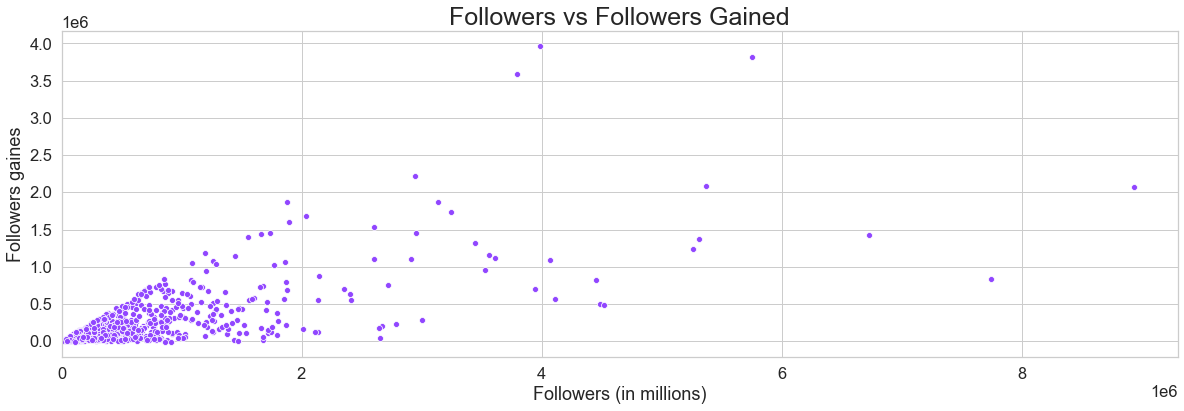

In [155]:
# Scatter plot
plt.figure(figsize=(20, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1.5)

line = sns.scatterplot(x='Followers', y='Followers gained', data=df_twitch,  color = "#9146ff")
line.set(xlabel='Followers (in millions)', ylabel='Followers gaines')
line.set_title('Followers vs Followers Gained', fontdict={'fontsize': 25})
plt.xlim(left=0, right=9.3e6)

plt.savefig("../../reports/figures/FollowersvsFollowersgained.png", bbox_inches='tight', dpi=500)

Text(0.5, 1.0, 'Peak viewers vs Followers Gained')

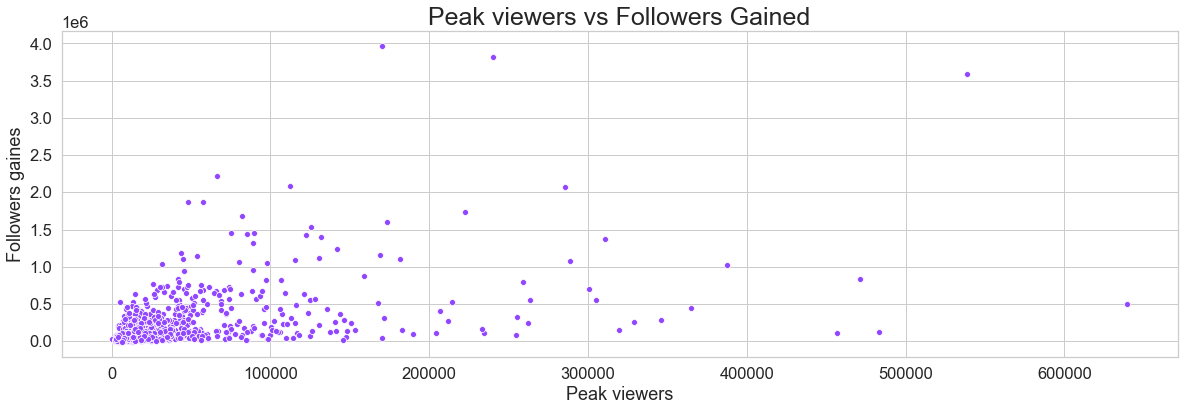

In [20]:
# Scatter plot
plt.figure(figsize=(20, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1.5)

line = sns.scatterplot(x='Peak viewers', y='Followers gained', data=df_twitch,  color = "#9146ff")
line.set(xlabel='Peak viewers', ylabel='Followers gaines')
line.set_title('Peak viewers vs Followers Gained', fontdict={'fontsize': 25})

[Text(0.5, 0, 'Watch time'),
 Text(0, 0.5, 'Followers gained'),
 Text(0.5, 1.0, 'Average viewers vs Followers Gained Corr')]

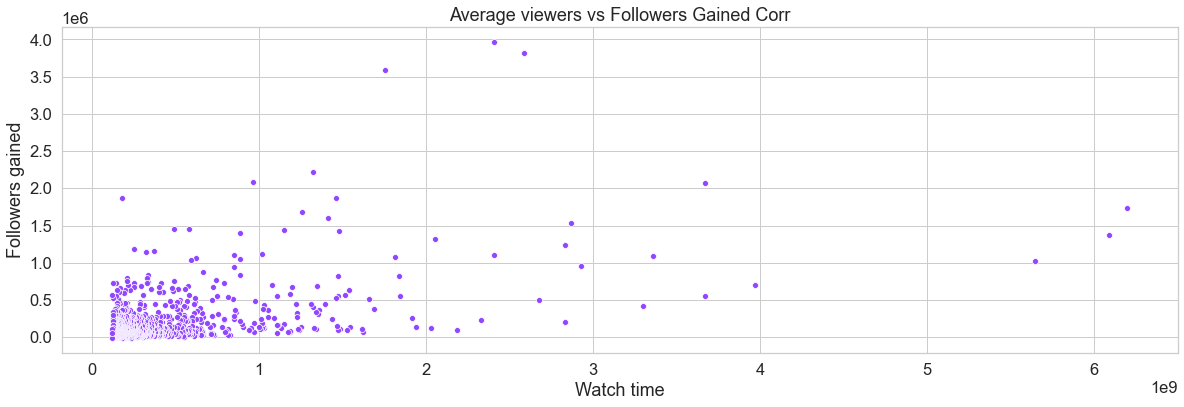

In [21]:
# Scatter plot
plt.figure(figsize=(20, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1.5)

scat2 = sns.scatterplot(x='Watch time(Minutes)', y='Followers gained', data=df_twitch,  color = "#9146ff")
scat2.set(xlabel='Watch time', ylabel='Followers gained', title='Average viewers vs Followers Gained Corr')

#plt.savefig("../../reports/figures/LikesvsMaxLiveView.png", bbox_inches='tight', dpi=500)

# Data Preprocessing 

In [22]:
# Separating target y from features X

X = df_twitch.drop(['Followers gained'], axis=1)
y = df_twitch['Followers gained']

In [23]:
y_df = y.sort_values(ascending = False)
y_df

Channel
auronplay         3966525
Rubius            3820532
TheGrefg          3593081
Bugha             2220765
pokimane          2085831
                   ...   
voicetv              1328
Dyrus                 111
마스카 (newmasca)      -4942
Amaz                -5405
TSM_TheOddOne      -15772
Name: Followers gained, Length: 1000, dtype: int64

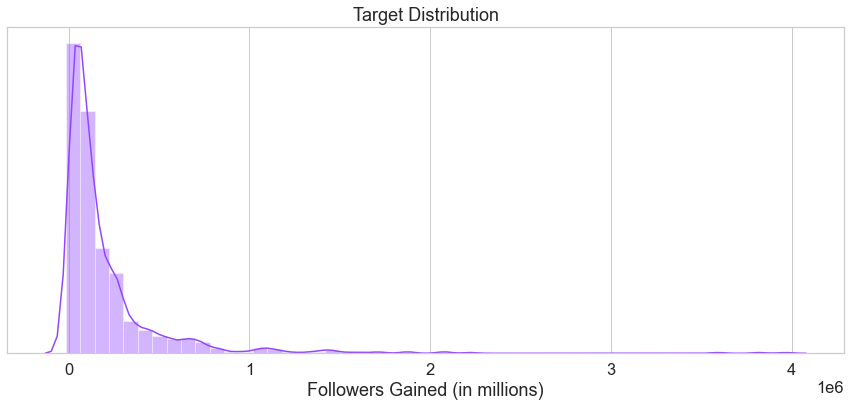

In [24]:
# Plot Target Distribution

plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1.5)

target_dist = sns.distplot(y, color = "#9146ff")
target_dist.set(xlabel='Followers Gained (in millions)', title='Target Distribution', yticks=[])

plt.savefig("../../reports/figures/Target_Dist.png", bbox_inches='tight', dpi=500)

In [25]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

#X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.25)

In [26]:
# Creating data frames for plotting final model performances

df_train = X_train.merge(y_train, on='Channel')
df_test = X_test.merge(y_test, on='Channel')

#df_t1 = X_t.merge(y_t, on='Channel')

In [94]:
ss = StandardScaler()
ss.fit(X_train)
X_t_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# FSM: Linear Regression

Linear Regression Model as First Simple Model

In [27]:
# Create linear regression object
fsm = LinearRegression()

# Train the model using the training sets
fsm.fit(X_train, y_train)

In [29]:
# Let's quickly check R2 score on training data
fsm.score(X_train, y_train)

0.6035289794000956

In [31]:
# Mean Absolute Percentage Error
y_pred_lr = fsm.predict(X_train)
MAPE(y_train, y_pred_lr)

636.6663198456981

In [33]:
# Cross-validation
scores = cross_val_score(fsm, X_train, y_train, cv=5).mean()
scores

0.43339462829722153

Model R2 for the test data

In [35]:
# Make predictions using the testing set
y_pred_lr = fsm.predict(X_test)

fsm.score(X_test, y_test)

0.3554379115985269

In [51]:
X_test['Followers']

Channel
Alderiate         319860
SmallAnt          255156
逼比 (bebelolz)     260119
Datto             530822
cdewx             380159
                  ...   
dota2ti_ru        541644
Sykkuno           334591
Rainbow6         1501197
ZeratoR           880728
Shotz             159763
Name: Followers, Length: 250, dtype: int64

In [41]:
y_test.shape

(250,)

Coefficients: 
 [ 3.48572839e-05 -2.64917222e-01 -1.74978675e-01  5.34314065e+00
  2.92800474e-01  7.04642418e-05 -5.61710417e+04 -2.05851930e+03
  9.37799043e+03]
Mean absolute percentage error: 180.47
Coefficient of determination: 0.355438


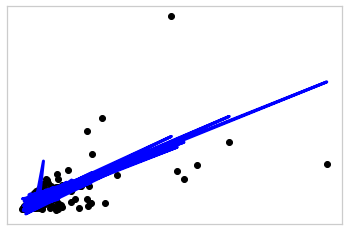

In [55]:
# The coefficients
print('Coefficients: \n', fsm.coef_)
# The mean absolut percentage error
print('Mean absolute percentage error: %.2f'
      % MAPE(y_test, y_pred_lr))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %3f'
      % r2_score(y_test, y_pred_lr))

# Plot outputs
plt.scatter(X_test['Followers'], y_test,  color='black')
plt.plot(X_test['Followers'], y_pred_lr, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

### Random Forest 

Let's run Random Forest

In [56]:
rfr = RandomForestRegressor()

In [57]:
# Define the parameter grid
grid = {
    'n_estimators': [100, 1000],
    'max_features': ["auto", "sqrt", "log2"],
    'max_depth': [None, 3, 5, 10, 25],
    'min_samples_leaf': [1, 5, 10]
    #'criterion' : ["mse", "mae"]
    
}

In [58]:
# Initialize the gridsearch object with three-fold cross-validation
gs = GridSearchCV(rfr, grid, cv=3)

In [59]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 3, 5, 10, 25],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [100, 1000]})

In [60]:
gs.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'n_estimators': 100}

In [66]:
gs.best_params_['min_samples_leaf']

5

In [61]:
gs.best_score_

0.5119322810723757

In [62]:
y_pred_gs = gs.predict(X_train)
MAPE(y_train, y_pred_gs)

357.00981363846245

In [63]:
x1 = (y_train - y_pred_gs) / y_train

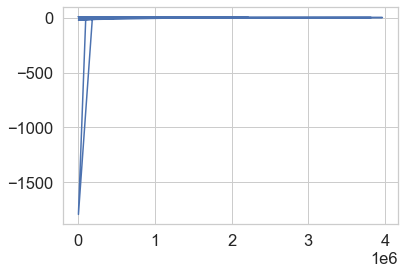

In [64]:
plt.plot(y_train, x1)

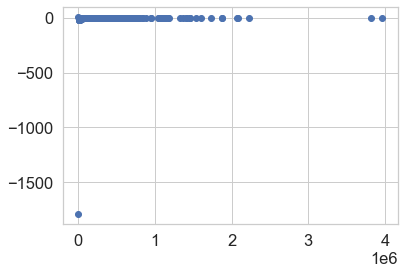

In [65]:
scatplot = plt.scatter(y_train, x1)
scatplot

In [67]:
rfr_final = RandomForestRegressor(n_estimators=gs.best_params_['n_estimators'], min_samples_leaf=gs.best_params_['min_samples_leaf'], random_state=42, max_features=gs.best_params_['max_features'], max_depth=gs.best_params_['max_depth']) 

In [68]:
rfr_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=5, random_state=42)

In [69]:
rfr_final.score(X_train, y_train)

0.7393984751951534

In [70]:
y_pred_rf = rfr_final.predict(X_train)

In [71]:
MAPE(y_train, y_pred_rf)

334.142983797486

In [72]:
# Cross-validation on the train set
scores = cross_val_score(rfr, X_train, y_train, cv=5).mean()
scores

0.5542697068123024

In [94]:
# Cross-validation on the test set
scores = cross_val_score(rfr, X_test, y_test, cv=5)
scores

array([-2.1313888 ,  0.39107054,  0.38736415,  0.39183532,  0.10204655])

In [76]:
y_pred_rf = rfr_final.predict(X_test)

In [78]:
print('Mean absolute percentage error: %.2f'
      % MAPE(y_test, y_pred_rf))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %2f'
      % r2_score(y_test, y_pred_rf))

Mean absolute percentage error: 157.23
Coefficient of determination: 0.543051


In [79]:
# Feature importance
rfr_final.feature_importances_

array([1.41756691e-02, 2.82341526e-02, 6.90329591e-02, 3.83874411e-02,
       7.85994431e-01, 2.19855074e-02, 0.00000000e+00, 7.89368354e-05,
       4.21109029e-02])

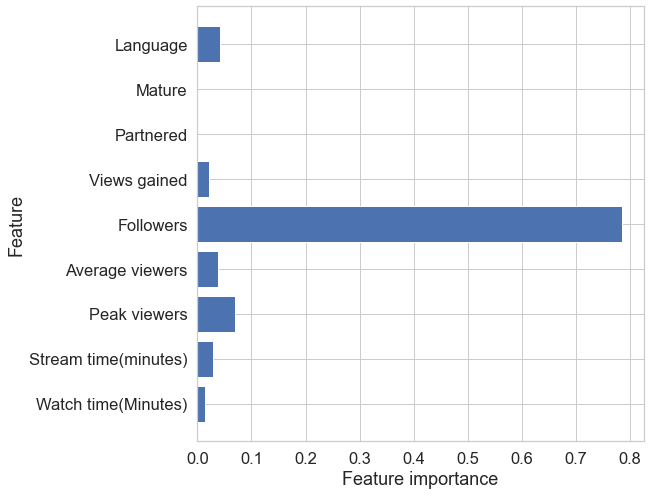

In [80]:
plot_feature_importances(rfr_final, X_test)

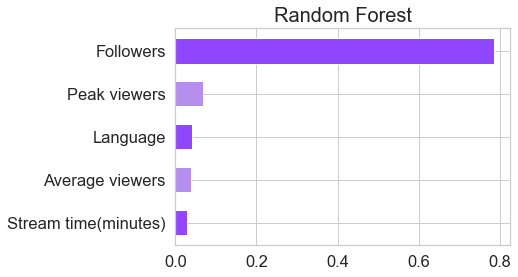

In [81]:
plot_top5_feature_importances(rfr_final, X_test, 'Random Forest')

#plt.savefig("../../reports/figures/RF_5_feature_importances.png", bbox_inches='tight', dpi=400)

### Poisson Regressor

The data falls on Poisson distribution and meet all the requirements. The target is a random number of a gained followers over given period of time.   

In [82]:
df_twitch_drop = df_twitch[df_twitch['Followers gained'] < 200].index
df_twitch_drop

Index(['Amaz', 'TSM_TheOddOne', 'Dyrus', '마스카 (newmasca)'], dtype='object', name='Channel')

In [83]:
df_twitch_pr = df_twitch.drop(df_twitch_drop)

In [95]:
X_pr = df_twitch_pr.drop(['Followers gained'], axis=1)
y_pr = df_twitch_pr['Followers gained']

In [96]:
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X_pr, y_pr, random_state=42, test_size=0.25)

In [98]:
ss = StandardScaler()
ss.fit(X_train_pr)
X_t_ss = ss.transform(X_train_pr)
X_test_ss = ss.transform(X_test_pr)

In [145]:
df_train_pr = X_train_pr.merge(y_train_pr, on='Channel')
df_test_pr = X_test_pr.merge(y_test_pr, on='Channel')

In [84]:
pr = PoissonRegressor(max_iter=1000)

In [99]:
pr.fit(X_t_ss, y_train_pr)

PoissonRegressor(max_iter=1000)

In [100]:
pr.score(X_t_ss, y_train_pr)

0.559705232546283

In [101]:
pr.fit(X_test_ss, y_test_pr)

PoissonRegressor(max_iter=1000)

In [105]:
y_pred_pr = pr.predict(X_t_ss)

In [106]:
y_pred_pr1 = pr.predict(X_test_ss)

In [104]:
pr.score(X_test_ss, y_test_pr)

0.5057687130606446

In [102]:
# Cross-validation
scores = cross_val_score(pr, X_t_ss, y_train_pr, cv=5).mean()
scores

0.34251414705591576

In [109]:
# Mean Absolute Percentage Error

MAPE(y_train_pr, y_pred_pr)

181.867809148869

In [110]:

MAPE(y_test_pr, y_pred_pr1)

169.4819522229862

In [111]:
pr.coef_

array([ 0.37513949, -0.3713011 ,  0.08705404, -0.13643353,  0.2122797 ,
       -0.10348411,  0.10776351, -0.07964111,  0.18795188])

In [114]:
print('Mean absolute percentage error: %.2f'
      % MAPE(y_test_pr, y_pred_pr1))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %2f'
      % r2_score(y_test_pr, y_pred_pr1))

Mean absolute percentage error: 169.48
Coefficient of determination: 0.518742


In [118]:
from operator import itemgetter

Text(0.5, 1.0, 'Poisson Regression')

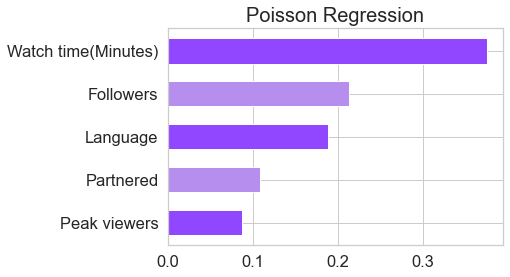

In [120]:
summary = list(zip(X_train_pr.columns, pr.coef_))
summary = sorted(summary, key=itemgetter(1), reverse=True)
summary
ylabel = [i[0] for i in summary][:5]
xlabel = [i[1] for i in summary][:5]
fig, ax = plt.subplots()

ax.barh(ylabel, xlabel, height=0.6, color=['#9146ff', '#b58eee'])
ax.invert_yaxis()

ax.axes.set_title('Poisson Regression', fontsize=20)

In [140]:
plot_top5_feature_importances(pr, X_train_pr, 'Poisson Regressor', coef_)

#plt.savefig("../../reports/figures/PR_5_feature_importances.png", bbox_inches='tight', dpi=400)

NameError: name 'coef_' is not defined

### K-Nearest Neighbors Regressor

Let's try KNN, it should perform well, cause this is a small data set.

In [121]:
knn = KNeighborsRegressor()

In [122]:
# Define the parameter grid
grid_knn = {
    'n_neighbors': [5, 10, 25],
    'weights': ["uniform", "distance"],
    'leaf_size': [1, 5, 10]
    
}

In [123]:
# Initialize the gridsearch object with three-fold cross-validation
gs_knn = GridSearchCV(knn, grid_knn, cv=3)

In [124]:
gs_knn.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [1, 5, 10], 'n_neighbors': [5, 10, 25],
                         'weights': ['uniform', 'distance']})

In [125]:
gs_knn.best_params_

{'leaf_size': 1, 'n_neighbors': 25, 'weights': 'uniform'}

In [157]:
gs_knn.best_score_

0.15993128248636626

In [128]:
y_pred_knn = gs_knn.predict(X_train)
MAPE(y_train, y_pred_knn)

356.72572921358926

In [131]:
y_pred_knn = gs_knn.predict(X_test)

In [129]:
# Cross-validation
scores = cross_val_score(gs_knn, X_train, y_train, cv=5).mean()
scores

0.19046801305291558

In [159]:
print('Mean absolute percentage error: %.2f'
      % MAPE(y_test, y_pred_knn))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %2f'
      % r2_score(y_test, y_pred_knn))

Mean absolute percentage error: 247.17
Coefficient of determination: 0.211498


In [130]:
plot_top5_feature_importances(gs_knn, X_train, 'Poisson Regressor')

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

### Plotting Final Results

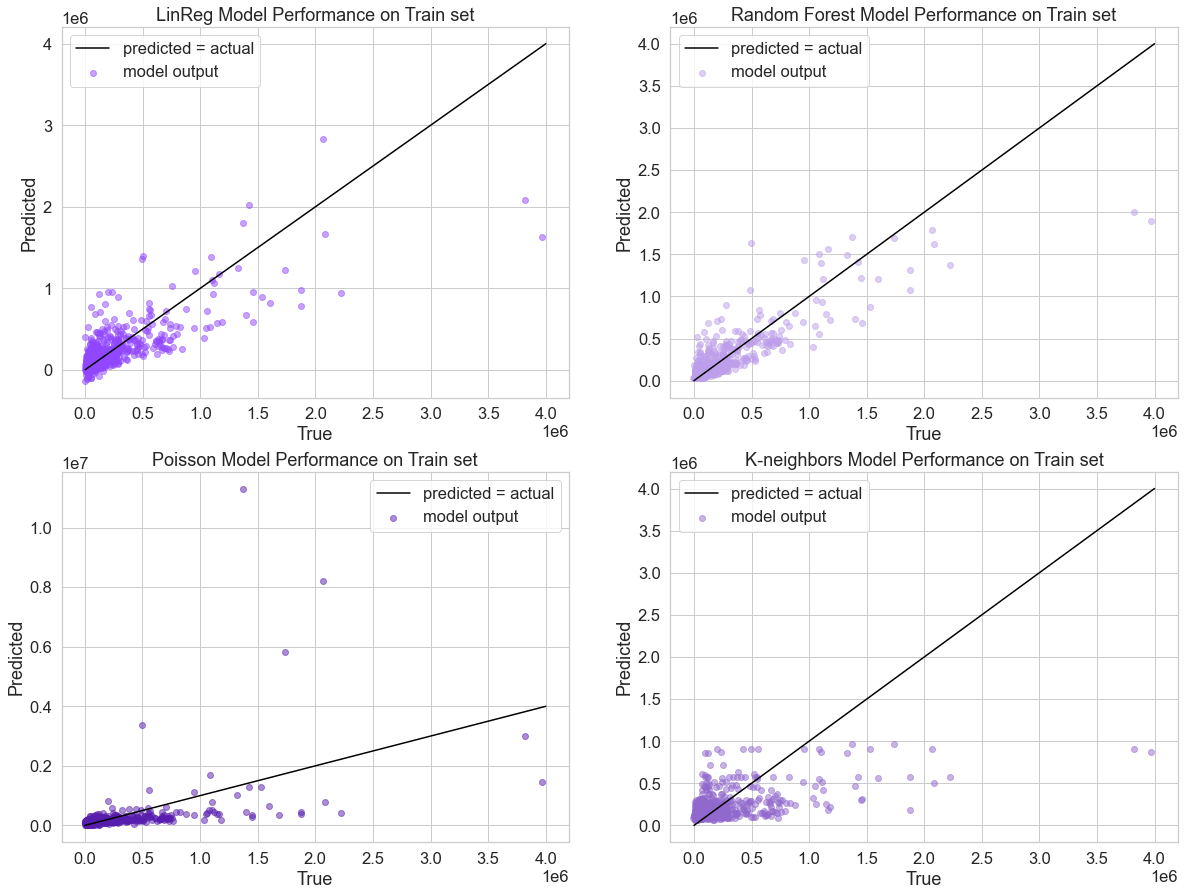

In [134]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

# Customize which model is actually being plotted
ax1.set_title("LinReg Model Performance on Train set")
ax1.scatter(y_train, fsm.predict(X_train),
                alpha=0.5, label="model output", color=ppt_colors[0])

ax2.set_title("Random Forest Model Performance on Train set")
ax2.scatter(y_train, rfr_final.predict(X_train),
                alpha=0.5, label="model output", color=ppt_colors[3])

ax3.set_title("Poisson Model Performance on Train set")
ax3.scatter(y_train_pr, pr.predict(X_t_ss),
                alpha=0.5, label="model output", color=ppt_colors[1])

ax4.set_title("K-neighbors Model Performance on Train set")
ax4.scatter(y_train, gs_knn.predict(X_train),
                alpha=0.5, label="model output", color=ppt_colors[2])

# Same setup for both plots (x and y labels, line showing y=x)
y_equals_x = np.linspace(0, 4e6)
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.plot(y_equals_x, y_equals_x, label="predicted = actual", color="black")
    ax.legend()

plt.savefig("../../reports/figures/Models_performances.png", bbox_inches='tight', dpi=400)

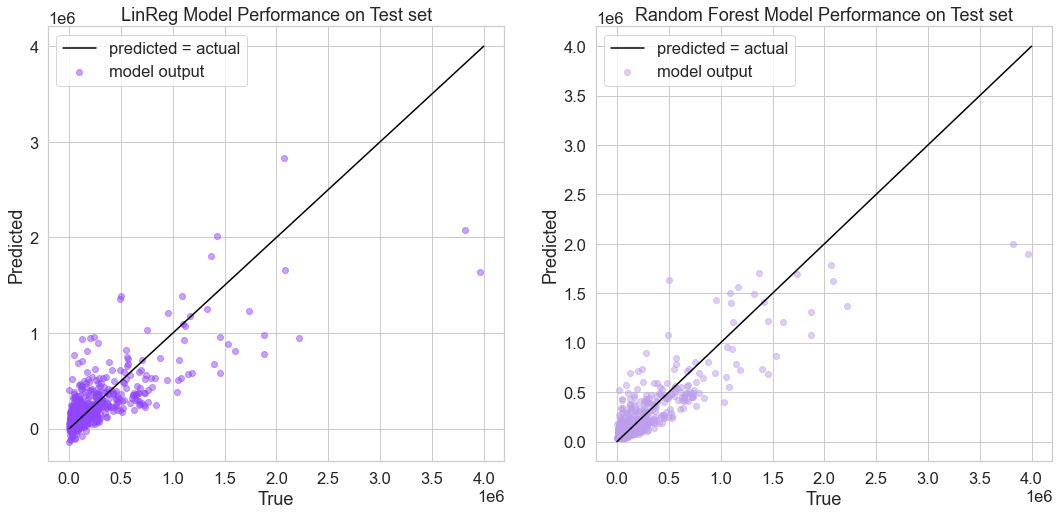

In [141]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Customize which model is actually being plotted
ax1.set_title("LinReg Model Performance on Test set")
ax1.scatter(y_train, fsm.predict(X_train),
                alpha=0.5, label="model output", color=ppt_colors[0])

ax2.set_title("Random Forest Model Performance on Test set")
ax2.scatter(y_train, rfr_final.predict(X_train),
                alpha=0.5, label="model output", color=ppt_colors[3])

# Same setup for both plots (x and y labels, line showing y=x)
y_equals_x = np.linspace(0, 4e6)
for ax in (ax1, ax2):
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.plot(y_equals_x, y_equals_x, label="predicted = actual", color="black")
    ax.legend()

#plt.savefig("../../reports/figures/Models_performances.png", bbox_inches='tight', dpi=400)

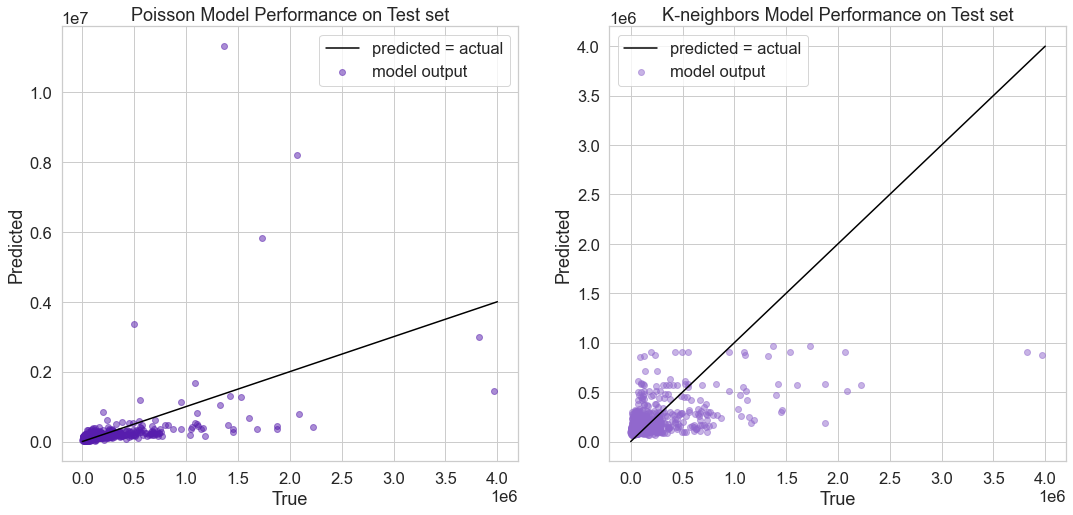

In [142]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Customize which model is actually being plotted
ax1.set_title("Poisson Model Performance on Test set")
ax1.scatter(y_train_pr, pr.predict(X_t_ss),
                alpha=0.5, label="model output", color=ppt_colors[1])

ax2.set_title("K-neighbors Model Performance on Test set")
ax2.scatter(y_train, gs_knn.predict(X_train),
                alpha=0.5, label="model output", color=ppt_colors[2])

# Same setup for both plots (x and y labels, line showing y=x)
y_equals_x = np.linspace(0, 4e6)
for ax in (ax1, ax2):
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.plot(y_equals_x, y_equals_x, label="predicted = actual", color="black")
    ax.legend()

#plt.savefig("../../reports/figures/Models_performances.png", bbox_inches='tight', dpi=400)

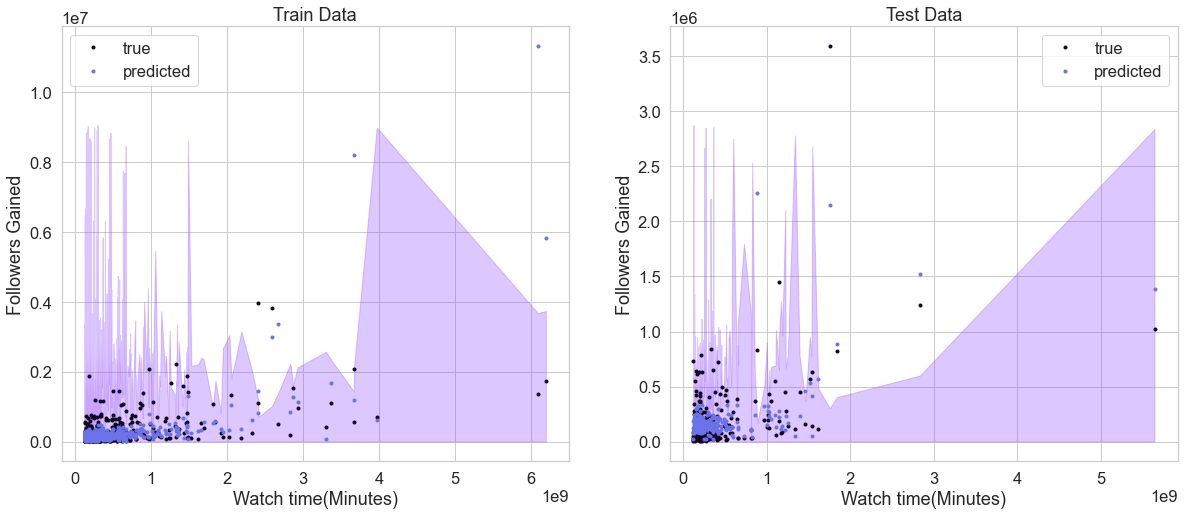

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(
    df=df_train_pr,
    feature="Watch time(Minutes)",
    weight="Stream time(minutes)",
    true="Followers gained",
    predicted=pr.predict(X_t_ss),
    y_label="Followers Gained",
    title="Train Data",
    ax=ax[0],
    fill_legend=False
)

plot_obs_pred(
    df=df_test_pr,
    feature="Watch time(Minutes)",
    weight="Stream time(minutes)",
    true="Followers gained",
    predicted=pr.predict(X_test_ss),
    y_label="Followers Gained",
    title="Test Data",
    ax=ax[1],
    fill_legend=False
)

#plt.savefig("../../reports/figures/Poisson_Model_performances.png", bbox_inches='tight', dpi=400)
#plt.show()

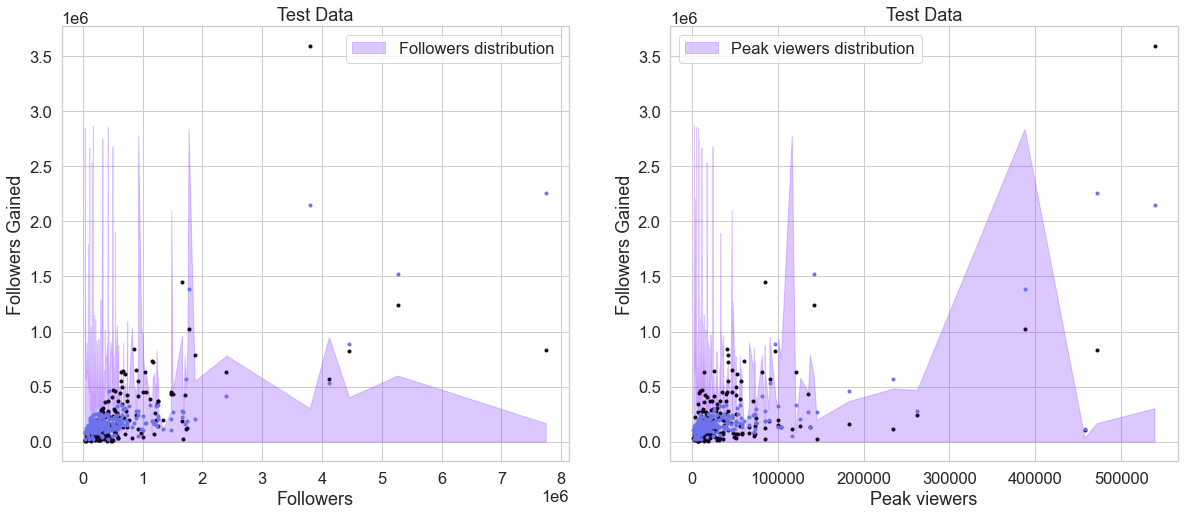

In [160]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(
    df=df_test_pr,
    feature="Followers",
    weight="Stream time(minutes)",
    true="Followers gained",
    predicted=pr.predict(X_test_ss),
    y_label="Followers Gained",
    title="Test Data",
    ax=ax[0],
    fill_legend=True
)

plot_obs_pred(
    df=df_test_pr,
    feature="Peak viewers",
    weight="Stream time(minutes)",
    true="Followers gained",
    predicted=pr.predict(X_test_ss),
    y_label="Followers Gained",
    title="Test Data",
    ax=ax[1],
    fill_legend=True
)

#plt.savefig("../../reports/figures/Poisson_Model_performances.png", bbox_inches='tight', dpi=400)
#plt.show()

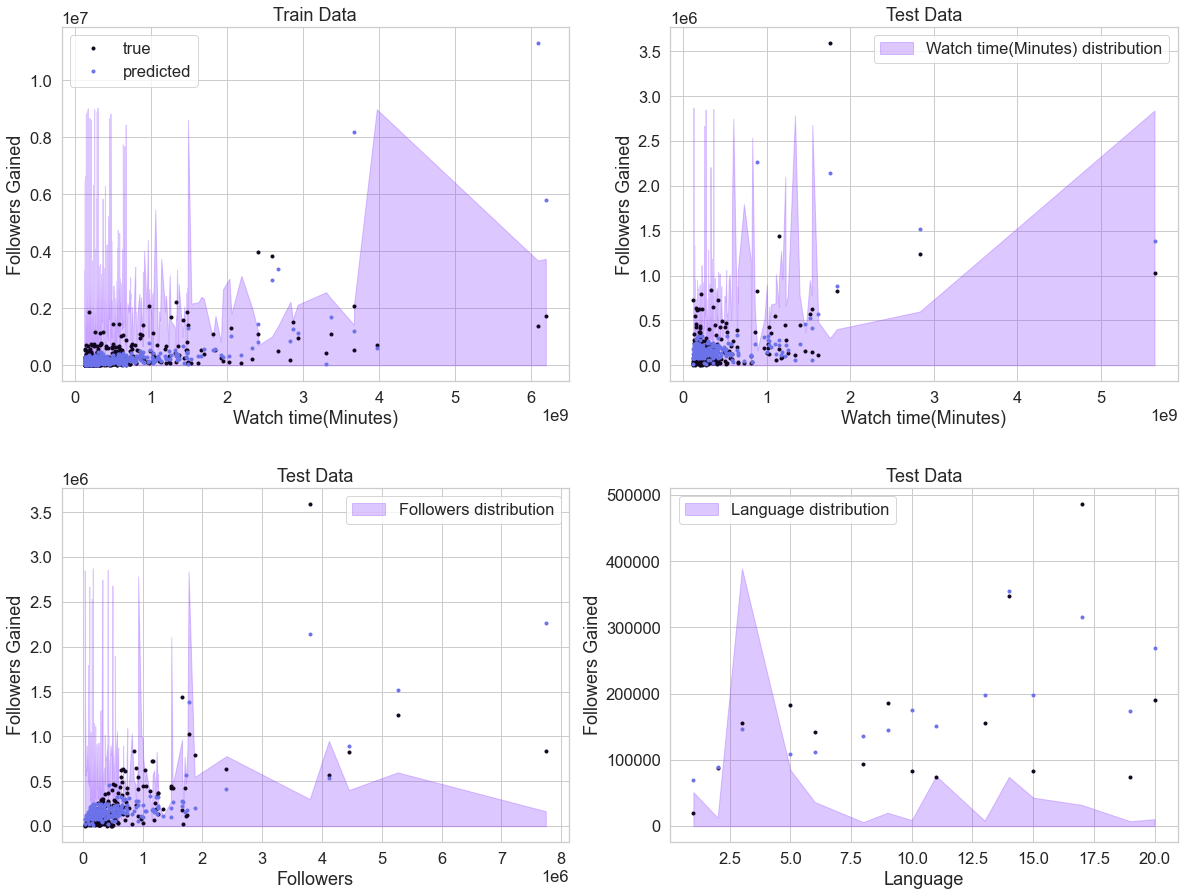

In [116]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(
    df=df_train,
    feature="Watch time(Minutes)",
    weight="Stream time(minutes)",
    true="Followers gained",
    predicted=pr.predict(X_t_ss),
    y_label="Followers Gained",
    title="Train Data",
    ax=ax[0, 0],
)

plot_obs_pred(
    df=df_test,
    feature="Watch time(Minutes)",
    weight="Stream time(minutes)",
    true="Followers gained",
    predicted=pr.predict(X_test_ss),
    y_label="Followers Gained",
    title="Test Data",
    ax=ax[0, 1],
    fill_legend=True
)

plot_obs_pred(
    df=df_test,
    feature="Followers",
    weight="Stream time(minutes)",
    true="Followers gained",
    predicted=pr.predict(X_test_ss),
    y_label="Followers Gained",
    title="Test Data",
    ax=ax[1, 0],
    fill_legend=True
)

plot_obs_pred(
    df=df_test,
    feature="Language",
    weight="Stream time(minutes)",
    true="Followers gained",
    predicted=pr.predict(X_test_ss),
    y_label="Followers Gained",
    title="Test Data",
    ax=ax[1, 1],
    fill_legend=True
)

plt.savefig("../../reports/figures/Poisson_Model_performances.png", bbox_inches='tight', dpi=400)
plt.show()

### Summary